# The Flowers Dataset

In [1]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import numpy as np
import random as python_random
from tensorflow.keras.applications import VGG16
from keras import layers, models
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import drive
import tarfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Loading the dataset

We start by loading the data from our Drive folder:

In [2]:
drive.mount('/content/gdrive')
# Path to your .tgz file
file_path = 'gdrive/My Drive/Colab Notebooks/flower_photos.tgz'

# Extract the contents
with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall('/content/')

Mounted at /content/gdrive


In [3]:
batch_size = 32
img_height = 224
img_width = 224

def load_data(folder_path):
    X = []
    y = []
    class_names = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    print("Class names:", class_names)

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                image = load_img(image_path, target_size=(224, 224)) # change image size from original to make them of same shape
                image = img_to_array(image)
                X.append(image)
                y.append(i)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
    X = np.array(X)
    y = np.array(y)
    return X, y, class_names

# Load the data
X, y, class_names = load_data('flower_photos')

Class names: ['roses', 'sunflowers', 'tulips', 'daisy', 'dandelion']


# Preprocessing

We normalize the dataset, and provide the augmentation using the module $\texttt{keras.layers.experimental.preprocessing}$.

In [4]:
def split_data(X, y, train_size, val_size, test_size, random_state=None):

    if train_size + val_size + test_size != 1.0:
        raise ValueError("The sum of train_size, val_size, and test_size must be 1.0")

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size + test_size), random_state=random_state)
    remaining_proportion = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1 - remaining_proportion), random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

Normalizing image data by dividing by 255 is a common practice because pixel values in typical images are represented as integers in the range [0, 255]. This range corresponds to an 8-bit representation of pixel intensities, where 0 represents black and 255 represents white in grayscale images.

In [5]:
# Normalize data first:

X_normalized = X/255.

In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_normalized, y,
                                                            train_size=0.8,
                                                            val_size=0.1,
                                                            test_size=0.1,
                                                            random_state=42)

In [7]:
# Delete unused data, to prevent RAM from going boom

del(X)
del(X_normalized)

In [8]:
# Sequence of modules to place before the actual NN

data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal',input_shape = (224,224,3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
    keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

# Transfer Learning


## Prepraring the pretrained network

In [ ]:

resnet_layer= keras.applications.ResNet50(include_top=False,weights="imagenet",input_shape=(224,224,3),pooling="avg",)
resnet_layer.trainable = False


inputs = keras.layers.Input(shape=(224, 224, 3))

x = keras.applications.resnet.preprocess_input(inputs)

x = resnet_layer(x)

x = keras.layers.Dense(1024, activation='relu')(x)

outputs = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [10]:
# Encode classes in valid format
n_classes=5
y_train_encoded = to_categorical(y_train, n_classes)
y_val_encoded = to_categorical(y_val, n_classes)

# Include if you want to stop when not improving anymore
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

## Training the new classifier

In [ ]:
# for the moment fix LR and epochs

lr = 0.005
epochs = 5


In [ ]:
# Compile the model
optimizer = Adam(learning_rate=lr)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 5)                 5125  

In [ ]:
# Fit the model

history = model.fit(
    x=X_train,
    y=y_train_encoded,
    epochs=epochs,
    validation_data=(X_val, y_val_encoded),
    callbacks=[early_stopping],
    batch_size=batch_size,
    #class_weight=class_weight_dict
)

Epoch 1/5
92/92 [==============================] - 23s 162ms/step - loss: 2.3444 - accuracy: 0.2684 - val_loss: 1.5414 - val_accuracy: 0.2779
Epoch 2/5
92/92 [==============================] - 10s 105ms/step - loss: 1.4998 - accuracy: 0.3433 - val_loss: 1.4946 - val_accuracy: 0.3297
Epoch 3/5
92/92 [==============================] - 10s 105ms/step - loss: 1.4846 - accuracy: 0.3512 - val_loss: 1.4947 - val_accuracy: 0.3324
Epoch 4/5
92/92 [==============================] - 10s 111ms/step - loss: 1.4609 - accuracy: 0.3716 - val_loss: 1.4944 - val_accuracy: 0.3270
Epoch 5/5
92/92 [==============================] - 10s 111ms/step - loss: 1.4402 - accuracy: 0.3760 - val_loss: 1.4740 - val_accuracy: 0.3324


In [ ]:
lr = 0.001
epochs = 10

In [ ]:
optimizer = Adam(learning_rate=lr)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
history2 = model.fit(
    x=X_train,
    y=y_train_encoded,
    epochs=epochs,
    validation_data=(X_val, y_val_encoded),
    callbacks=[early_stopping],
    batch_size=batch_size,
    #class_weight=class_weight_dict
)

Epoch 1/10
92/92 [==============================] - 15s 126ms/step - loss: 1.3893 - accuracy: 0.3971 - val_loss: 1.4310 - val_accuracy: 0.3406
Epoch 2/10
92/92 [==============================] - 10s 111ms/step - loss: 1.3852 - accuracy: 0.4043 - val_loss: 1.4287 - val_accuracy: 0.3515
Epoch 3/10
92/92 [==============================] - 10s 110ms/step - loss: 1.3820 - accuracy: 0.4111 - val_loss: 1.4252 - val_accuracy: 0.3515
Epoch 4/10
92/92 [==============================] - 10s 112ms/step - loss: 1.3751 - accuracy: 0.4019 - val_loss: 1.4193 - val_accuracy: 0.3651
Epoch 5/10
92/92 [==============================] - 10s 112ms/step - loss: 1.3761 - accuracy: 0.4050 - val_loss: 1.4170 - val_accuracy: 0.3597
Epoch 6/10
92/92 [==============================] - 10s 111ms/step - loss: 1.3770 - accuracy: 0.4009 - val_loss: 1.4189 - val_accuracy: 0.3706
Epoch 7/10
92/92 [==============================] - 10s 112ms/step - loss: 1.3661 - accuracy: 0.4169 - val_loss: 1.4077 - val_accuracy: 0.3842

In [ ]:
# Save the model to Google Drive
drive.mount('/content/gdrive')

model_save_path = 'gdrive/My Drive/Colab Notebooks/flower_classification_TRANSFER_model.h5'
model.save(model_save_path)

# Load the model from Google Drive
model_load_path = 'gdrive/My Drive/Colab Notebooks/flower_classification_TRANSFER_model.h5'
loaded_model = tf.keras.models.load_model(model_load_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## With data augmentation

In [11]:

resnet_layer= keras.applications.ResNet50(include_top=False,weights="imagenet",input_shape=(224,224,3),pooling="avg",)
resnet_layer.trainable = False


inputs = keras.layers.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)

x = keras.applications.resnet.preprocess_input(x)

x = resnet_layer(x)

x = keras.layers.Dense(1024, activation='relu')(x)

outputs = keras.layers.Dense(5, activation='softmax')(x)

model_aug = keras.Model(inputs=inputs, outputs=outputs)

94765736/94765736 [==============================] - 0s 0us/step


In [12]:
# for the moment fix LR and epochs

lr = 0.005
epochs = 5
n_classes = 5

In [13]:
# Compile the model
optimizer = Adam(learning_rate=lr)

model_aug.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [14]:
# Fit the model

history_aug = model_aug.fit(
    x=X_train,
    y=y_train_encoded,
    epochs=epochs,
    validation_data=(X_val, y_val_encoded),
    callbacks=[early_stopping],
    batch_size=batch_size,
    #class_weight=class_weight_dict
)

Epoch 1/5
92/92 [==============================] - 25s 182ms/step - loss: 1.8741 - accuracy: 0.2916 - val_loss: 1.5415 - val_accuracy: 0.3188
Epoch 2/5
92/92 [==============================] - 13s 138ms/step - loss: 1.5288 - accuracy: 0.3396 - val_loss: 1.5045 - val_accuracy: 0.3542
Epoch 3/5
92/92 [==============================] - 12s 132ms/step - loss: 1.5001 - accuracy: 0.3382 - val_loss: 1.5183 - val_accuracy: 0.3025
Epoch 4/5
92/92 [==============================] - 12s 125ms/step - loss: 1.5098 - accuracy: 0.3372 - val_loss: 1.4889 - val_accuracy: 0.3406
Epoch 5/5
92/92 [==============================] - 11s 124ms/step - loss: 1.4702 - accuracy: 0.3696 - val_loss: 1.4891 - val_accuracy: 0.3270


In [15]:
# Print model summary
model_aug.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1024)              209817

In [16]:
# lower lr

lr = 0.001
epochs = 15


In [17]:
# Compile the model
optimizer = Adam(learning_rate=lr)

model_aug.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [18]:
# Fit the model

history_aug = model_aug.fit(
    x=X_train,
    y=y_train_encoded,
    epochs=epochs,
    validation_data=(X_val, y_val_encoded),
    callbacks=[early_stopping],
    batch_size=batch_size,
    #class_weight=class_weight_dict
)

Epoch 1/15
92/92 [==============================] - 19s 148ms/step - loss: 1.4319 - accuracy: 0.3954 - val_loss: 1.4660 - val_accuracy: 0.3569
Epoch 2/15
92/92 [==============================] - 12s 126ms/step - loss: 1.4205 - accuracy: 0.3839 - val_loss: 1.4723 - val_accuracy: 0.3324
Epoch 3/15
92/92 [==============================] - 12s 127ms/step - loss: 1.4172 - accuracy: 0.3982 - val_loss: 1.4685 - val_accuracy: 0.3542
Epoch 4/15
92/92 [==============================] - 12s 128ms/step - loss: 1.4023 - accuracy: 0.4152 - val_loss: 1.4574 - val_accuracy: 0.3569
Epoch 5/15
92/92 [==============================] - 12s 127ms/step - loss: 1.4026 - accuracy: 0.4060 - val_loss: 1.4439 - val_accuracy: 0.3733
Epoch 6/15
92/92 [==============================] - 12s 130ms/step - loss: 1.3988 - accuracy: 0.4067 - val_loss: 1.4342 - val_accuracy: 0.3569
Epoch 7/15
92/92 [==============================] - 11s 124ms/step - loss: 1.3952 - accuracy: 0.4138 - val_loss: 1.4344 - val_accuracy: 0.3706

In [19]:
# Save the model to Google Drive
drive.mount('/content/gdrive')

model_save_path = 'gdrive/My Drive/Colab Notebooks/flower_classification_AUG_TRANSFER_model.h5'
model_aug.save(model_save_path)

# Load the model from Google Drive
model_load_path = 'gdrive/My Drive/Colab Notebooks/flower_classification_AUG_TRANSFER_model.h5'
loaded_model_aug = tf.keras.models.load_model(model_load_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# History results

## Without data augmentation

In [ ]:
# Assuming you have the history dictionary loaded
history_dict = history.history

# Create a DataFrame from the history dictionary
history_df = pd.DataFrame(history_dict)

# Add an epoch column
history_df['epoch'] = history_df.index + 1

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df, x='epoch', y='accuracy', label='Training Accuracy', marker='o')
sns.lineplot(data=history_df, x='epoch', y='val_accuracy', label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
sns.lineplot(data=history_df, x='epoch', y='loss', label='Training Loss', marker='o')
sns.lineplot(data=history_df, x='epoch', y='val_loss', label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
#plt.savefig("accuracy-withoutAUG.png")
#files.download("accuracy-withoutAUG.png")
plt.show()

## With data augmentation

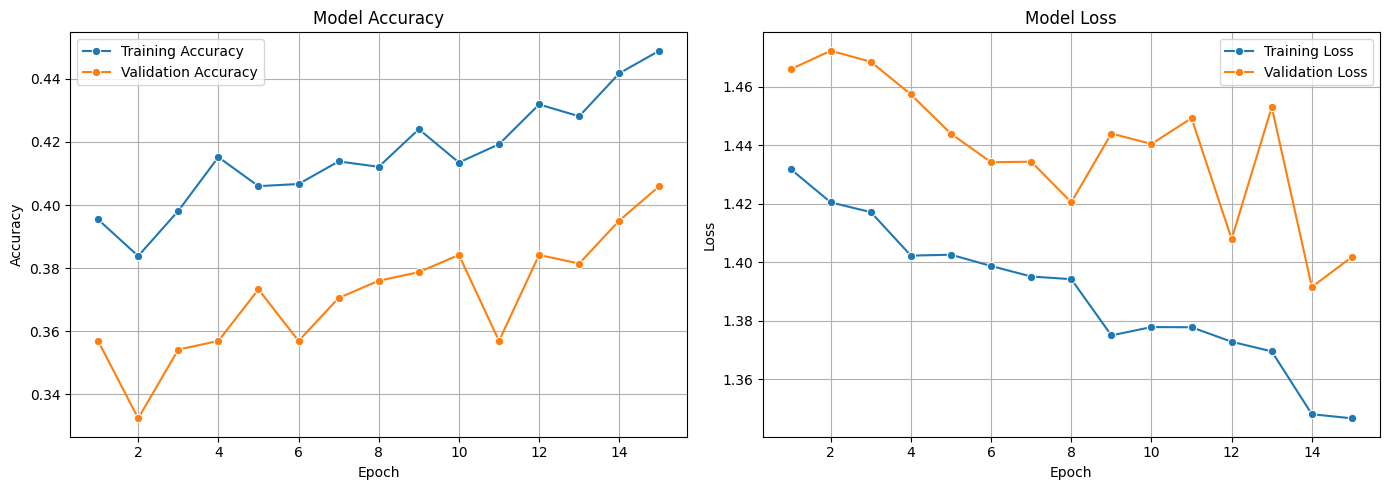

In [21]:
# Assuming you have the history dictionary loaded
history_dict_aug = history_aug.history

# Create a DataFrame from the history dictionary
history_df_aug = pd.DataFrame(history_dict_aug)

# Add an epoch column
history_df_aug['epoch'] = history_df_aug.index + 1

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df_aug, x='epoch', y='accuracy', label='Training Accuracy', marker='o')
sns.lineplot(data=history_df_aug, x='epoch', y='val_accuracy', label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
sns.lineplot(data=history_df_aug, x='epoch', y='loss', label='Training Loss', marker='o')
sns.lineplot(data=history_df_aug, x='epoch', y='val_loss', label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
#plt.savefig("accuracy-withAUG.png")
#files.download("accuracy-withAUG.png")
plt.show()

12/12 [==============================] - 2s 100ms/step
Confusion Matrix:
[[ 6  8 23 27 10]
 [ 1 44 11  4  5]
 [ 7 16 30 19 11]
 [ 1 10 12 29  5]
 [ 3 10 12  9 54]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

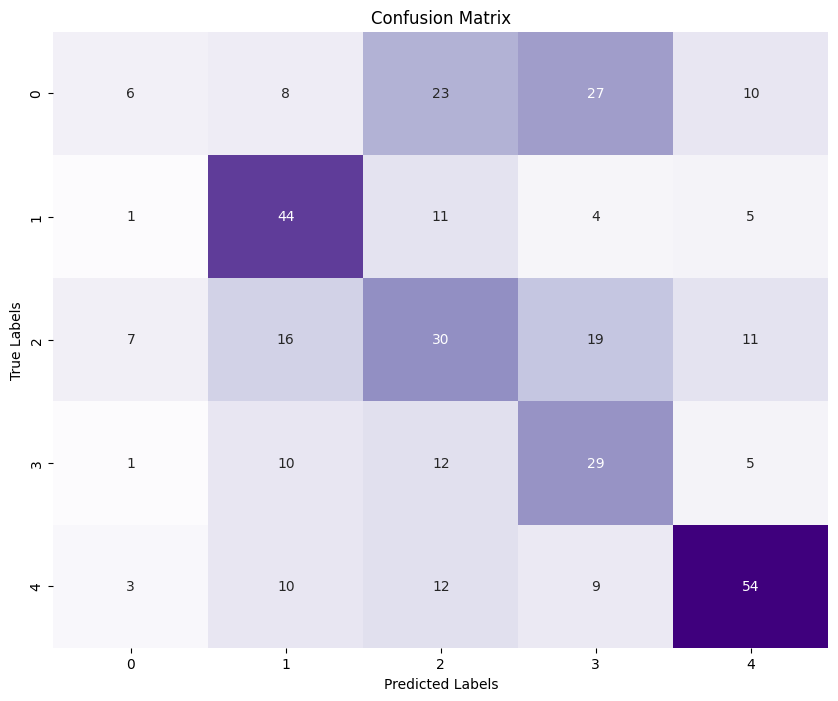

In [20]:
y_pred_aug = loaded_model_aug.predict(X_test)

# Convert probabilities to class labels
y_pred_classes_aug = np.argmax(y_pred_aug, axis=1)

# Now you can compute the confusion matrix
cm_aug = confusion_matrix(y_test, y_pred_classes_aug)

# Print confusion matrix
print("Confusion Matrix:")
print(cm_aug)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("CM-withAUG.png")
files.download("CM-withAUG.png")
plt.show()

12/12 [==============================] - 5s 112ms/step
Confusion Matrix:
[[21  0 23 14 16]
 [12  0 38  2 13]
 [12  0 44 11 16]
 [13  0 14 22  8]
 [ 5  0 17  5 61]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

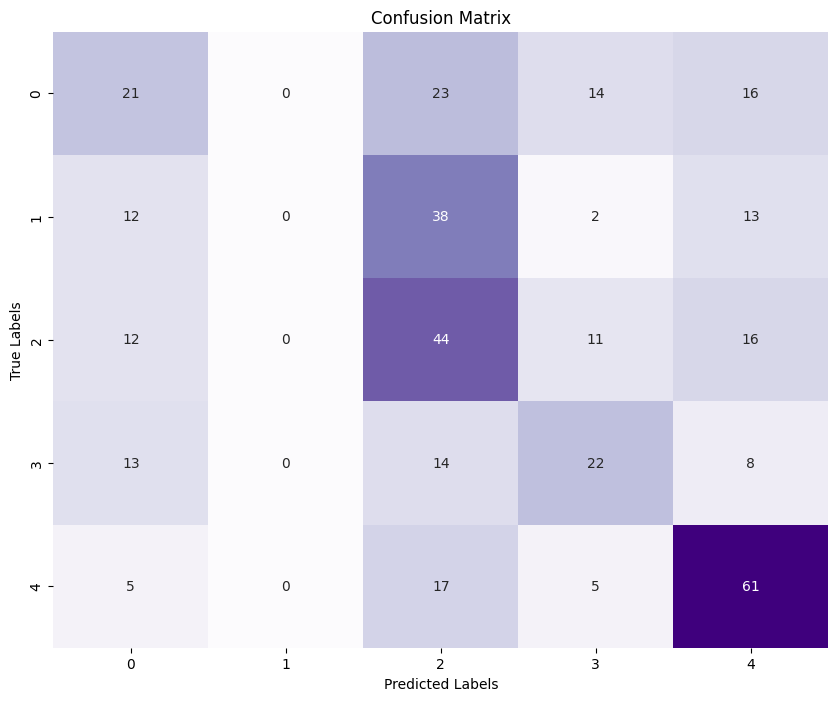

In [ ]:
y_pred = loaded_model.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Now you can compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("CM-withoutAUG.png")
files.download("CM-withoutAUG.png")
plt.show()